In [1]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import pandas as pd
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
import json
import os

Using Theano backend.
Using cuDNN version 5103 on context None
Mapped name None to device cuda: Quadro P4000 (0000:00:05.0)


In [2]:
def ConvBlock(filters, model, layers):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [3]:
def FullyConnectedLayer(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [4]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]

In [5]:
def ft(model, num):
    model.pop()
    for layer in model.layers: layer.trainable=False
    model.add(Dense(num, activation='softmax'))
    model = compile(model)
    return model

def finetune(model, batches):
    model = ft(model, batches.nb_class)
    classes = list(iter(batches.class_indices)) # get a list of all the class labels
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
    return model, classes


def compile(model, lr=0.001):
    model.compile(optimizer=Adam(lr=lr),
            loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def fit(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
            validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    return model

In [6]:
def VGGModel():
    model= Sequential()
    model.add(Lambda(preprocess, input_shape=(3,224,224)))
    ConvBlock(64, model, 2)
    ConvBlock(128, model, 2)
    ConvBlock(256, model, 3)
    ConvBlock(512, model, 3)
    ConvBlock(512, model, 3)
    
    model.add(Flatten())
    FullyConnectedLayer(model)
    FullyConnectedLayer(model)
    model.add(Dense(1000, activation='softmax'))
    return model
    

In [7]:
batch_size = 32
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    print path+dirname
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [8]:
path = '../../data/redux/'

In [9]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [10]:
model = VGGModel()

/home/paperspace/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [11]:
model_weight = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(model_weight)

In [12]:
import utils; reload(utils)
from utils import plots

In [14]:
train_batches = get_batches('train', batch_size=batch_size)
# print train_batches.filenames
val_batches = get_batches('valid', batch_size=batch_size)

../../data/redux/train
Found 23000 images belonging to 2 classes.
../../data/redux/valid
Found 2000 images belonging to 2 classes.


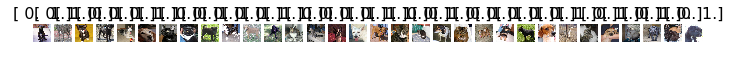

In [15]:
images, labels = next(train_batches)
plots(images, titles=labels)

In [16]:
model, classes = finetune(model, train_batches)
type(model)

keras.models.Sequential

In [17]:
model = fit(model, train_batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 537s - loss: 0.1325 - acc: 0.9699 - val_loss: 0.0792 - val_acc: 0.9850


In [18]:
type(model)

keras.models.Sequential

In [19]:
print path+'test'
print batch_size
test_batches = get_batches('test', shuffle=False, batch_size=32, class_mode=None)
test_images = next(test_batches)
test_batches.nb_sample

../../data/redux/test
32
../../data/redux/test
Found 12500 images belonging to 1 classes.


12500

In [20]:
def pred_batch(model, imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes))
    print('First 5 probabilities: {}\n'.format(preds))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [21]:
def pred_generator(model, test_batches):
    preds = model.predict_generator(test_batches, test_batches.nb_sample)
    idxs = np.argmax(preds, axis=1)
    prob = preds[:,1]
    print preds[:10]
    print idxs[:10]
    print prob[:10]
    return prob

In [22]:
filenames = list(test_batches.filenames)
filenames = [os.path.basename(i).replace('.jpg', '') for i in filenames]
filenames = map(int, filenames)
filenames[:10]

[828, 10093, 2205, 11812, 4042, 6038, 9620, 2297, 7548, 4079]

In [23]:
# prediction = model.predict_generator(test_batches, test_batches.nb_sample)
prob = pred_generator(model, test_batches)

[[  2.8245e-11   1.0000e+00]
 [  8.4789e-10   1.0000e+00]
 [  1.0000e+00   1.5185e-10]
 [  1.0000e+00   1.6681e-11]
 [  1.0000e+00   1.3294e-16]
 [  1.0000e+00   1.0562e-13]
 [  1.0000e+00   4.1475e-06]
 [  3.7636e-07   1.0000e+00]
 [  1.2280e-11   1.0000e+00]
 [  1.8874e-12   1.0000e+00]]
[1 1 0 0 0 0 0 1 1 1]
[  1.0000e+00   1.0000e+00   1.5185e-10   1.6681e-11   1.3294e-16   1.0562e-13   4.1475e-06
   1.0000e+00   1.0000e+00   1.0000e+00]


In [ ]:
prob.shape
# print list(prob)
# prob_ = prob.reshape(1,12500)
# prob_.shape
# print type(prob)

In [ ]:
# model.summary()

In [27]:
submission_df = pd.DataFrame({'id':filenames, 'label':list(prob)})
print submission_df.shape
print submission_df.head(10)
submission_df.to_csv("submission.csv", index=False)

(12500, 2)
      id         label
0    828  1.000000e+00
1  10093  1.000000e+00
2   2205  1.518474e-10
3  11812  1.668121e-11
4   4042  1.329421e-16
5   6038  1.056189e-13
6   9620  4.147532e-06
7   2297  9.999996e-01
8   7548  1.000000e+00
9   4079  1.000000e+00


In [ ]:
# pred_batch(model, test_images)